# Comparing ECMWF and La ReUnion forecasts against La ReUnion Best Track data

This notebook looks at the two sources and compares the performance and review which cyclones would be activated historically.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from datetime import datetime
import os

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from src.datasources import codab, helpers, rsmc
from src.constants import *
from src.utils import *

In [3]:
save_dir = rsmc.DATA_DIR / "public" / "exploration" / "moz" / "ecmwf_hindcast"

In [4]:
# Complete list of storms
storm_cerf_file = pd.read_csv(
    rsmc.DATA_DIR / "public" / "raw" / "moz" / "storms_cerf_data.csv"
)

In [5]:
all_storms = storm_cerf_file["storm"]

<Axes: >

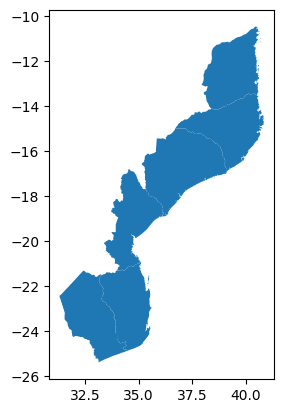

In [6]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

<Axes: >

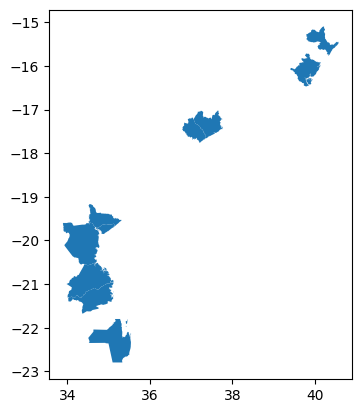

In [ ]:
adm2_path = (
    rsmc.DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)

adm2 = gpd.read_file(adm2_path)
adm2_sel = adm2[adm2["ADM2_PT"].isin(ADMS2)]
adm2_sel.plot()

In [8]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [9]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)

In [10]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)

In [11]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)

<Axes: >

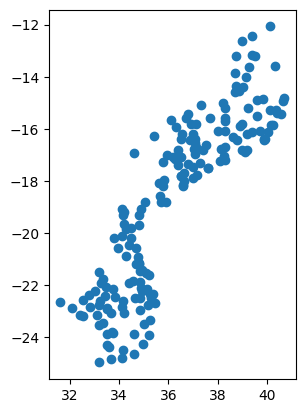

In [12]:
cyclone_tracks_sel.plot()

In [13]:
cyclone_tracks_sel["Name"].unique()

array(['FILAO', 'DESSILIA', 'NADIA', 'BONITA', 'LISETTE', 'A19798',
       'ASTRIDE', 'ELINE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       '720052006', 'FAVIO', 'JAYA', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', '920132014', 'GUITO', 'HELLEN', 'CHEDZA',
       'DINEO', '420172018', 'DESMOND', 'IDAI', 'KENNETH', 'CHALANE',
       'ELOISE', 'GUAMBE', 'ANA', 'DUMAKO', 'GOMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

In [14]:
df = rsmc.load_historical_forecast_distances()

In [15]:
ibtracs_path = rsmc.DATA_DIR / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)

In [ ]:
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * MIN1_TO_MIN10
)
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])

In [17]:
df = df[df["name"].isin(all_storms)]

La ReUnion forecasts vs Best Track Data

In [18]:
df.columns

Index(['valid_time', 'lt_hour', 'latitude', 'longitude', 'max_wind_kt',
       'season', 'name', 'numberseason', 'issue_time', 'MZ03_distance_km',
       'MZ07_distance_km', 'MZ09_distance_km', 'MZ11_distance_km'],
      dtype='object')

Adding which cyclones would be triggered using ECMWF

In [19]:
ecmwf_cyclone_data = helpers.load_all_cyclone_csvs(save_dir)
ecmwf_cyclone_data["lat"] = ecmwf_cyclone_data["lat"].apply(
    lambda x: -x if x > 0 else x
)
interpolated_ecmwf_data = helpers.interpolate_cyclone_tracks(
    ecmwf_cyclone_data
)

In [20]:
ecmwf_cyclone_gdf = gpd.GeoDataFrame(
    ecmwf_cyclone_data,
    geometry=gpd.points_from_xy(
        ecmwf_cyclone_data.lon, ecmwf_cyclone_data.lat
    ),
    crs="EPSG:4326",  # Assuming WGS84
)
ecmwf_cyclones_on_land = gpd.sjoin(
    ecmwf_cyclone_gdf, adm2_sel, how="inner", predicate="intersects"
)
ecmwf_cyclones_on_land_obs = gpd.sjoin(
    ecmwf_cyclone_gdf, adm, how="inner", predicate="intersects"
)

In [ ]:
# readiness
readiness_storms = ecmwf_cyclones_on_land[
    ((ecmwf_cyclones_on_land["lead_time"] > 72))
    & (ecmwf_cyclones_on_land["speed"] >= (48 * KNOTS2MS))
]["cyclone_name"].unique()
readiness_storms

array(['FAVIO', 'IZILDA', 'IDAI', 'CHALANE', 'ELOISE', 'GOMBE', 'FREDDY'],
      dtype=object)

In [ ]:
# action
action_storms = ecmwf_cyclones_on_land[
    ((ecmwf_cyclones_on_land["lead_time"] >= 6))
    & (ecmwf_cyclones_on_land["lead_time"] <= 72)
    & (ecmwf_cyclones_on_land["speed"] >= (48 * KNOTS2MS))
]["cyclone_name"].unique()
action_storms

array(['FAVIO', 'JOKWE', 'IDAI', 'CHALANE', 'ELOISE', 'GOMBE', 'FREDDY',
       'FILIPO'], dtype=object)

In [ ]:
# observational
obs_ws_storms = ecmwf_cyclones_on_land_obs[
    ((ecmwf_cyclones_on_land_obs["lead_time"] == 0))
    & (ecmwf_cyclones_on_land_obs["speed"] >= (48 * KNOTS2MS))
]["cyclone_name"].unique()
obs_ws_storms

array(['IDAI', 'ANA', 'FREDDY'], dtype=object)

In [ ]:
interpolated_ecmwf_data[
    (interpolated_ecmwf_data["cyclone_name"] == "FREDDY")
    & (interpolated_ecmwf_data["speed"] >= 48 * KNOTS2MS)
]

,time,forecast_time,speed,lat,lon,lead_time,cyclone_name
10371,2023-03-04 21:30:00+00:00,"2023/03/02, 12:00:0",24.700,-22.075000,40.833333,52.5,FREDDY
10372,2023-03-04 22:00:00+00:00,"2023/03/02, 12:00:0",25.000,-22.100000,40.866667,54.0,FREDDY
10373,2023-03-04 22:30:00+00:00,"2023/03/02, 12:00:0",25.300,-22.125000,40.900000,55.5,FREDDY
10374,2023-03-04 23:00:00+00:00,"2023/03/02, 12:00:0",25.600,-22.150000,40.933333,57.0,FREDDY
10375,2023-03-04 23:30:00+00:00,"2023/03/02, 12:00:0",25.900,-22.175000,40.966667,58.5,FREDDY
...,...,...,...,...,...,...,...
11212,2023-03-22 10:00:00+00:00,"2023/03/02, 12:00:0",25.200,-32.233333,37.233333,238.0,FREDDY
11213,2023-03-22 10:30:00+00:00,"2023/03/02, 12:00:0",25.325,-32.400000,37.300000,238.5,FREDDY
11214,2023-03-22 11:00:00+00:00,"2023/03/02, 12:00:0",25.450,-32.566667,37.366667,239.0,FREDDY
11215,2023-03-22 11:30:00+00:00,"2023/03/02, 12:00:0",25.575,-32.733333,37.433333,239.5,FREDDY


In [ ]:
# Lists of storm events
df = storm_cerf_file.copy()
df["Readiness"] = [storm in readiness_storms for storm in all_storms]
df["Action"] = [storm in action_storms for storm in all_storms]
df["Observational Wind Speed"] = [
    storm in obs_ws_storms for storm in all_storms
]
df = df[
    [
        "storm",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Total Affected",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)


# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            # "Observational Rainfall",
            "Observational Wind Speed",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,storm,Readiness,Action,Observational Wind Speed,Total Affected,CERF Allocations
12,IDAI,True,True,True,"1,628,167","14,018,121"
20,FREDDY,True,True,True,"1,230,691","9,995,213"
10,DINEO,False,False,False,"750,102","2,000,095"
18,GOMBE,True,True,False,"736,015","4,018,682"
15,ELOISE,True,True,False,"481,901",
22,CHIDO,False,False,False,"453,971","3,999,970"
13,KENNETH,False,False,False,"400,094","9,964,907"
24,JUDE,False,False,False,"385,000","6,053,738"
23,DIKELEDI,False,False,False,"283,334",
1,JOKWE,False,True,False,"220,013","548,913"


Adding which cyclones would be triggered using La ReUnion

In [26]:
df_rsmc_dist = rsmc.load_historical_forecast_distances()

In [46]:
df_rsmc = pd.read_parquet(
    rsmc.DATA_DIR
    / "private"
    / "processed"
    / "moz"
    / "rsmc"
    / "rsmc_forecasts_interp_distances_withradius.parquet"
)

In [ ]:
# adding buffer
df_rsmc["radius_max_wind_km"] = (
    df_rsmc["radius_max_wind_nm"].astype(float) * KPH2KNOTS
)

<Axes: >

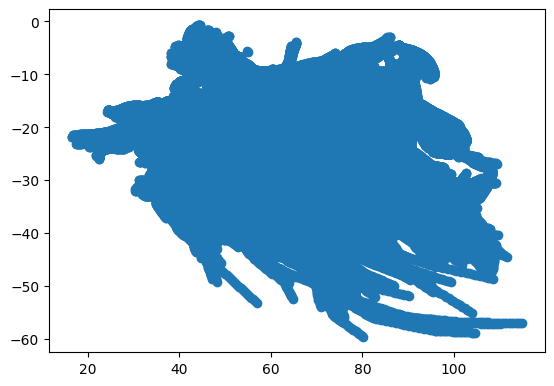

In [29]:
mf_lr_gdf = gpd.GeoDataFrame(
    df_rsmc,
    geometry=gpd.points_from_xy(df_rsmc.longitude, df_rsmc.latitude),
    crs="EPSG:4326",  # Assuming WGS84
)
mf_lr_gdf.plot()

In [ ]:
mf_lr_gdf_buffer = mf_lr_gdf.copy()
mf_lr_gdf_buffer["radius_max_wind_km"] = (
    mf_lr_gdf_buffer["radius_max_wind_km"].fillna(0.001).replace(0, 0.001)
)
mf_lr_gdf_buffer["geometry"] = mf_lr_gdf_buffer.geometry.buffer(
    mf_lr_gdf_buffer["radius_max_wind_km"] / KMS2DEGREE
)
mf_lr_gdf_buffer.plot()

In [31]:
mf_lr_on_land_adm1 = gpd.sjoin(
    mf_lr_gdf, adm, how="inner", predicate="intersects"
)
mf_lr_on_land_adm2 = gpd.sjoin(
    mf_lr_gdf, adm2_sel, how="inner", predicate="intersects"
)
mf_lr_on_land_adm2_buffer = gpd.sjoin(
    mf_lr_gdf_buffer, adm2_sel, how="inner", predicate="intersects"
)

In [32]:
mf_lr_on_land_adm1["name"].unique()  # cyclones that made it to land

array(['ANA', '0420172018', 'CHALANE', 'DUMAKO', 'DINEO', 'DANDO',
       'DESMOND', 'ELOISE', 'FREDDY', 'FUNSO', 'FILIPO', 'GIOVANNA',
       '0920132014', 'GOMBE', 'IRINA', 'IDAI', 'JASMINE', 'HELLEN',
       'KENNETH'], dtype=object)

In [33]:
# readiness
buffer = True
if buffer:
    mf_lr_on_land_adm2_df = mf_lr_on_land_adm2_buffer
else:
    mf_lr_on_land_adm2_df = mf_lr_on_land_adm2

In [89]:
speed_threshold = 64  # knots
max_lead_time = 96  # hours

In [90]:
# readiness
readiness_storms = mf_lr_on_land_adm1[
    ((mf_lr_on_land_adm1["lt_hour"] > max_lead_time))
    & (mf_lr_on_land_adm1["max_wind_kt"] >= (speed_threshold))
]["name"].unique()
readiness_storms = np.concatenate((readiness_storms, ["CHIDO"]))
readiness_storms

array(['ELOISE', 'FREDDY', 'FUNSO', 'IRINA', 'IDAI', 'HELLEN', 'CHIDO'],
      dtype=object)

In [91]:
# action
action_storms = mf_lr_on_land_adm1[
    ((mf_lr_on_land_adm1["lt_hour"] >= 6))
    & (mf_lr_on_land_adm1["lt_hour"] <= max_lead_time)
    & (mf_lr_on_land_adm1["max_wind_kt"] >= (speed_threshold))
]["name"].unique()
action_storms = np.concatenate((action_storms, ["CHIDO", "DIKELEDI", "JUDE"]))

action_storms

array(['DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IRINA', 'IDAI', 'KENNETH',
       'CHIDO', 'DIKELEDI', 'JUDE'], dtype=object)

In [92]:
# observational
obs_ws_storms = mf_lr_on_land_adm1[
    ((mf_lr_on_land_adm1["lt_hour"] < 6))
    & (mf_lr_on_land_adm1["max_wind_kt"] >= (speed_threshold))
]["name"].unique()
obs_ws_storms = np.concatenate((obs_ws_storms, ["CHIDO", "DIKELEDI", "JUDE"]))

obs_ws_storms

array(['DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH', 'CHIDO',
       'DIKELEDI', 'JUDE'], dtype=object)

In [ ]:
rain_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "daily_imerg_cyclone_landfall_fixed.csv"
)
imerg_data = rain_df[(rain_df["radius"] == 250)]
imerg_df = imerg_data[imerg_data["time_step"].isin([-1, 0, 1])]
imerg_sum_df = imerg_df.groupby("storm")["median_precip"].sum().reset_index()

obs_rain_storms = imerg_sum_df[imerg_sum_df["median_precip"] >= 55][
    "storm"
].unique()
# rename IDAI 1 to IDAI
obs_rain_storms[obs_rain_storms == "IDAI 1"] = "IDAI"
obs_rain_storms = np.concatenate((obs_rain_storms, ["JUDE", "DIKELEDI"]))
obs_rain_storms

array(['ANA', 'DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH',
       'JUDE', 'DIKELEDI'], dtype=object)

In [ ]:
# Lists of storm events
df["Readiness"] = [storm in readiness_storms for storm in all_storms]
df["Action"] = [storm in action_storms for storm in all_storms]
df["Observational Wind Speed"] = [
    storm in obs_ws_storms for storm in all_storms
]
df["Observational Rainfall"] = [
    storm in obs_rain_storms for storm in all_storms
]
df = df[
    [
        "storm",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Observational Rainfall",
        "Total Affected",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)

# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            "Observational Wind Speed",
            "Observational Rainfall",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,storm,Readiness,Action,Observational Wind Speed,Observational Rainfall,Total Affected,CERF Allocations
12,IDAI,True,True,True,True,"1,628,167","14,018,121"
20,FREDDY,True,True,True,True,"1,230,691","9,995,213"
10,DINEO,False,True,True,True,"750,102","2,000,095"
18,GOMBE,False,True,True,True,"736,015","4,018,682"
15,ELOISE,True,True,True,True,"481,901",
22,CHIDO,True,True,True,False,"453,971","3,999,970"
13,KENNETH,False,True,True,True,"400,094","9,964,907"
24,JUDE,False,True,True,True,"385,000","6,053,738"
23,DIKELEDI,False,True,True,True,"283,334",
1,JOKWE,False,False,False,False,"220,013","548,913"
